# Bayesian switchpoint analysis

Getting familiar with tensorflow-probability. Following [Bayesian Switchpoint Analysis](https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis)

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

tfp_d = tfp.distributions
tfp_b = tfp.bijectors


2021-10-16 13:09:25.539182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 13:09:25.539222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Dataset

Text(0, 0.5, 'Disaster count')

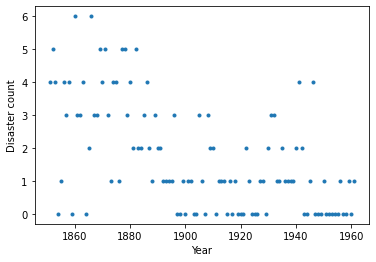

In [2]:
# 111 points all together
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

years = np.arange(1851, 1962)

fig, ax = pp.subplots()
ax.plot(years, disaster_data, '.')
ax.set_xlabel('Year')
ax.set_ylabel('Disaster count')

## Probabilistic model

Will slightly depart from the tutorial here. Don't see much value in declaring $s$ and $l$ to be exponentially distributed, as is done in the tutorial. The posterior for them is certainly not exponential.

The only value it, it would seem, that if $s$ and $l$ have a distribution attached to them, then one can easily sample from the distribution $D_t$, but this is not needed to define likelihood function.

### Sigmoid switch

The model for the number of disasters per year, $D_t$ is that the disasters arise with some rate $r_t$.

Disaster rate is assumed to be constant or at least random with stationary distribution for most of the time, but there is a change at some point in time.

$$
\begin{align}
\left(D_t\,| \, s,e,l\right) &\sim \mbox{Poisson}\left(r_t\right) \\
r_t&=e\:+\:\frac{l-e}{1+\exp\left((s-t)/\alpha\right)} \\
\end{align}
$$

Where $t \in \left[t_l,\,t_h\right]$ and $s>0$ and $l>0$. From the data it seems that maximum number of disasters per year is about 6, so set the upper limit at 20

### Defining model

The only thing that is really needed here is actually the likelihood function that includes all the available data

The PMF for Poisson distribution is:

$$
p\left(k\right)=\frac{\lambda^k\,\exp\left(-\lambda\right)}{k!}
$$

Hence the log-likelihood is:

$$
\log p\left(k\,\Big|\,\lambda\right)=k\cdot \log\lambda - \lambda -\sum_{i=1}^k i=k\cdot \log\lambda - \lambda- \frac{k\cdot\left(k+1\right)}{2}
$$


In [6]:
def log_lkhd_func(
    s,
    e,
    l,
    alpha,
    alpha_pedestal=1e-6,
    disaster_years=years,
    disaster_counts=disaster_data
):
    """
    Likelihood of data given parameters.
    
    Arguments:
    ----------
        * s - switch-point, i.e. year at which the rate switches
        * e - early disaster rate
        * l - late disaster rate
        * disaster_years - years for previously known disasters [1891, 1892, ....]
        * disaster_count - goes together with disaster_years, number of disasters that year
        * alpha - scale of sigmooid switch on in years, similar to scale of period span of the years involved.
        * alpha_pedestal - small value added to alpha to prevent division by zero
        * disaster_years - training data, years of the disaster
        * disaster_counts - training data, number of disasters in any specific years
        
    Returns:
    --------
        The log-likelihood of the data (disaster_years & disaster_counts) given the params
    """
    # get basic disaster rate
    disaster_rate = e + (l-e)/(1+tf.exp( (s-disaster_years)/(alpha+alpha_pedestal) ) )
    
    # get the log-likelihood for all the individual evens
    log_lkhd_arr = disaster_counts * tf.math.log(disaster_rate) - \
                    disaster_rate - \
                    ((disaster_counts+1)*disaster_counts)/2
    
    # pull to a total likelood
    log_lkhd = tf.math.reduce_sum(log_lkhd_arr)
    
    return log_lkhd

#
log_lkhd_func(tf.constant(1890.), tf.constant(3.1), tf.constant(0.92), tf.constant(5.))

<tf.Tensor: shape=(), dtype=float32, numpy=-462.4854>

## MCMC

Markov-Chain Monte-Carlo is needed here to sample from posterior distribution

In [12]:
@tf.function(autograph=False, jit_compile=True)
def hmc_sample_posterior(
    tgt_log_lkhd_fn,
    init_state,
    s_min,
    s_max,
    num_burnin_steps=1000,
    num_samples_per_chain=100
):
    """
    Initialize HMC kernel and run the chains. Note that passing list of three tensors with shape (chain_count, 1) 
    allows one to initialize severla chains. Returns the samples from the log_lkhd_fn as a tensor
    
    Arguments:
    ----------
        * tgt_log_lkhd_fn: log-likelihood function from which to draw the sample
        * init_state: [list of tensors or numpy] the three elements in the list will be the three arguments of the log-likelihood function
            making the tensors in the list of shape (chain_count,1) allows one to run multiple chains
        * s_min: minimum value for the s-param (used for bijector)
        * s_max: ditto max value
        * num_burnin_steps: number of transitions the chain needs to run before one can start drawing samples from it
        * num_samples_per_chain: how many examples of parameters to draw from each chain
        
    Returns:
    --------
        Tensor with sampling results
    """
    # runs a single iteration of the MCMC given the 
    # target probability distribution. 
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=tgt_log_lkhd_fn,
        step_size=0.05,
        num_leapfrog_steps=3
    )
    
    # transformed kernel
    # essentially inserts a bijective map before the inner kernel
    # the main effect is that log-probability density gets re-parametrized
    # in a new domain. This initial domain can be arbitrary, i.e. real line 
    # the bijectors then map the real line into something suitable, and then
    # that suitable domain gets fed into the inner kernel
    # target_log_prob(bij.forward(x)) + bij.forward_log_det_jacobian(x)
    # In the present example, s, i.e. the switch-point can only occur
    # between a fixed point of years we are considering. Once could feed the 
    # whole real line in, the Uniform distribition for `s` would simply send
    # to zero most of it - and that wouuld be a waste of time. So we map real line
    # into a fixed interval
    # similar story for `e` and `l` the early and later disaster rates. These are 
    # strictly non-negative, so it makes sense to map real line accordingly
    # alpha is also strictly non-negative, and is unlikely to be much above zero
    transformed_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel = hmc_kernel,
        bijector = [ # order of bijectors is dictated by the order of 
            # params in the target_log_prob_fn
            tfp_b.Sigmoid(low=tf.cast(s_min, dtype=tf.float32), high=tf.cast(s_max, dtype=tf.float32)),
            tfp_b.Softplus(),
            tfp_b.Softplus(),
            tfp_b.Softplus()
        ]
    )
    
    # adaptive step
    step_adapt_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = transformed_kernel,
        num_adaptation_steps = int(0.8 * num_burnin_steps)
    )
    
    # initialize the sampler and run chain(s) 
    samples = tfp.mcmc.sample_chain(
        num_results=num_samples_per_chain,
        num_burnin_steps=num_burnin_steps,
        current_state=init_state,
        trace_fn=None,
        kernel=step_adapt_kernel
    )
    
    return samples


####
chain_count = 50
samples_per_chain = 50

init_state = [
    tf.repeat(tf.constant([np.mean(years)], dtype=tf.float32, shape=(1,1)), axis=0, repeats=chain_count),
    tf.repeat(tf.constant([np.mean(disaster_data)], dtype=tf.float32, shape=(1,1)), axis=0, repeats=chain_count),
    tf.repeat(tf.constant([np.mean(disaster_data)], dtype=tf.float32, shape=(1,1)), axis=0, repeats=chain_count),
    tf.repeat(tf.constant([1.0], dtype=tf.float32, shape=(1,1)), axis=0, repeats=chain_count)
]

hmc_sample = hmc_sample_posterior(
    tgt_log_lkhd_fn = lambda *args: log_lkhd_func(*args),
    init_state=init_state,
    s_min=min(years),
    s_max=max(years),
    num_burnin_steps=10000,
    num_samples_per_chain=samples_per_chain
)

print('Done')

Done


Check the posterior distributions

Switch-point with 90% confidence: [1880.9, 1894.3]
Early disaster rate 90% confidence: [2.8, 4.2]
Late disaster rate 90% confidence: [0.6, 1.1]
Late disaster rate 90% confidence: [0.6, 1.1]


Text(0.5, 0, 'Switch scale (years)')

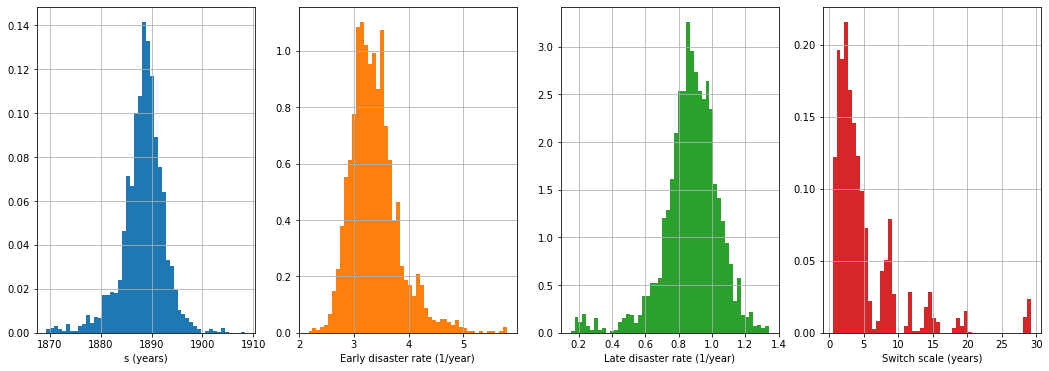

In [15]:
fig, (ax1, ax2, ax3, ax4) = pp.subplots(1, 4, figsize=(18, 6))

confidence_level = 0.9


s_arr = hmc_sample[0].numpy().reshape(-1)
s_ci_min = np.quantile(s_arr, (1-confidence_level)/2)
s_ci_max = np.quantile(s_arr, 1-((1-confidence_level)/2))
print(f'Switch-point with {confidence_level*100:.0f}% confidence: [{s_ci_min:.1f}, {s_ci_max:.1f}]')
#
_ = ax1.hist(s_arr, bins=50, density=True, color=cm.tab10(0))
ax1.grid()
ax1.set_xlabel('s (years)')


e_arr = hmc_sample[1].numpy().reshape(-1)
e_ci_min = np.quantile(e_arr, (1-confidence_level)/2)
e_ci_max = np.quantile(e_arr, 1-((1-confidence_level)/2))
print(f'Early disaster rate {confidence_level*100:.0f}% confidence: [{e_ci_min:.1f}, {e_ci_max:.1f}]')
#
_ = ax2.hist(e_arr, bins=50, density=True, color=cm.tab10(1))
ax2.grid()
ax2.set_xlabel('Early disaster rate (1/year)')


l_arr = hmc_sample[2].numpy().reshape(-1)
l_ci_min = np.quantile(l_arr, (1-confidence_level)/2)
l_ci_max = np.quantile(l_arr, 1-((1-confidence_level)/2))
print(f'Late disaster rate {confidence_level*100:.0f}% confidence: [{l_ci_min:.1f}, {l_ci_max:.1f}]')
#
_ = ax3.hist(l_arr, bins=50, density=True, color=cm.tab10(2))
ax3.grid()
ax3.set_xlabel('Late disaster rate (1/year)')


alpha_arr = hmc_sample[3].numpy().reshape(-1)
alpha_ci_min = np.quantile(alpha_arr, (1-confidence_level)/2)
alpha_ci_max = np.quantile(alpha_arr, 1-((1-confidence_level)/2))
print(f'Late disaster rate {confidence_level*100:.0f}% confidence: [{l_ci_min:.1f}, {l_ci_max:.1f}]')
#
_ = ax4.hist(alpha_arr, bins=50, density=True, color=cm.tab10(3))
ax4.grid()
ax4.set_xlabel('Switch scale (years)')

Values reported in the source for this [Bayesian Switchpoint Analysis](https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis), were (sigmoid):

| value name              | value 90% CI |
|-------------------------|--------------|
| early disaster rate (e) | [2.57, 3.74] |
| late disaster rate (l)  | [0.71, 1.16] |
| switch point            | [1886, 1895] |

Getting somewhat wider intervals here. The large values on switch scale deserve investigation in the future. Certainly 1 year (as implicitly assumed in the source) is not the most probable value.

Left for next time